In [5]:
import pandas as pd

file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/Database Requirements_Validation.xlsx"

# Load the FAQs sheet
df_faqs = pd.read_excel(file_path, sheet_name="FAQs")

print(f"✅ Loaded {len(df_faqs)} FAQ rows")
print(df_faqs.columns)

# Build validation dataframe
validation_df = pd.DataFrame({
    "id": range(len(df_faqs)),
    "query": df_faqs['Question'],
    "expected_answer": (
        df_faqs['Answer / Explanation'].fillna('') + " " +
        df_faqs['Legal Commentary'].fillna('') + " " +
        df_faqs['Government Regulation / Explanation'].fillna('')
    ),
    "rag_target": "GENERAL_QA"
})

✅ Loaded 183 FAQ rows
Index(['No.', 'Question', 'Answer / Explanation', 'Relevant Clause ID(s)',
       'Legal Commentary', 'Government Regulation / Explanation'],
      dtype='object')


In [6]:
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

retriever_rag2 = FAISS.load_local(
    "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa",
    embeddings,
    allow_dangerous_deserialization=True
).as_retriever()

print("✅ RAG 2 retriever loaded successfully!")


✅ RAG 2 retriever loaded successfully!


In [7]:
import pandas as pd
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# ----------------- Load RAG 2 Retriever -----------------
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

retriever_rag2 = FAISS.load_local(
    "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa",
    embeddings,
    allow_dangerous_deserialization=True
).as_retriever()

print("✅ RAG 2 retriever loaded successfully!")

# ----------------- Load Sentence Transformer -----------------
sim_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_threshold = 0.7
rouge_threshold = 0.5

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# ----------------- Add columns for validation -----------------
validation_df['retrieved_snippet'] = ''
validation_df['embedding_sim'] = 0.0
validation_df['rouge_l'] = 0.0
validation_df['hybrid_match'] = ''

# ----------------- Run validation -----------------
for i, row in validation_df.iterrows():
    query = row['query']
    
    # Retrieve top document
    docs = retriever_rag2.get_relevant_documents(query)[:1]
    retrieved = docs[0].page_content if docs else ""
    
    if retrieved:
        # Split into sentences
        sentences = [s.strip() for s in retrieved.split('.') if s.strip()]
        
        # Embedding similarity
        emb_expected = sim_model.encode([row['expected_answer']])
        emb_sentences = sim_model.encode(sentences)
        sims = cosine_similarity(emb_expected, emb_sentences)[0]
        max_idx = sims.argmax()
        best_sentence = sentences[max_idx]
        best_sim = sims[max_idx]
        
        # ROUGE-L score
        rouge_scores = scorer.score(row['expected_answer'], best_sentence)
        rouge_l_score = rouge_scores['rougeL'].fmeasure
    else:
        best_sentence = ""
        best_sim = 0.0
        rouge_l_score = 0.0
    
    # Store results
    validation_df.at[i, 'retrieved_snippet'] = best_sentence
    validation_df.at[i, 'embedding_sim'] = best_sim
    validation_df.at[i, 'rouge_l'] = rouge_l_score
    
    # Hybrid match: pass if either embedding or ROUGE-L passes threshold
    validation_df.at[i, 'hybrid_match'] = 'Y' if (best_sim >= embedding_threshold or rouge_l_score >= rouge_threshold) else 'N'

# ----------------- Compute overall hybrid accuracy -----------------
accuracy = (validation_df['hybrid_match'] == 'Y').mean() * 100
print(f"✅ Overall RAG 2 Hybrid Accuracy: {accuracy:.2f}%")

# ----------------- Save results -----------------
validation_df.to_csv("validation_results_hybrid.csv", index=False)
print("✅ Hybrid validation results saved to validation_results_hybrid.csv")


✅ RAG 2 retriever loaded successfully!


/var/folders/qv/l2xzz1097p1g1g5mslsj25vw0000gn/T/ipykernel_16698/1568809039.py:38: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever_rag2.get_relevant_documents(query)[:1]


✅ Overall RAG 2 Hybrid Accuracy: 31.69%
✅ Hybrid validation results saved to validation_results_hybrid.csv


In [8]:
import pandas as pd
from rouge_score import rouge_scorer
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# ----------------- Load RAG 2 Retriever -----------------
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

retriever_rag2 = FAISS.load_local(
    "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa",
    embeddings,
    allow_dangerous_deserialization=True
).as_retriever()

print("✅ RAG 2 retriever loaded successfully!")

# ----------------- Initialize models & thresholds -----------------
sim_model = SentenceTransformer("all-MiniLM-L6-v2")
similarity_threshold = 0.7   # for embeddings
rouge_threshold = 0.5        # for ROUGE-L
keyterm_threshold = 0.5      # fraction of keywords matched

# ----------------- Initialize ROUGE scorer -----------------
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# ----------------- Add columns for validation -----------------
validation_df['retrieved_answer'] = ''
validation_df['embedding_score'] = 0.0
validation_df['rouge_l'] = 0.0
validation_df['keyterm_score'] = 0.0
validation_df['hybrid_match'] = ''

# ----------------- Run hybrid validation -----------------
for i, row in validation_df.iterrows():
    query = row['query']
    expected = row['expected_answer']
    
    # Retrieve top document
    docs = retriever_rag2.get_relevant_documents(query)[:1]
    retrieved = docs[0].page_content if docs else ""
    validation_df.at[i, 'retrieved_answer'] = retrieved
    
    # 1️⃣ Embedding similarity
    if retrieved:
        emb_expected = sim_model.encode([expected])
        emb_retrieved = sim_model.encode([retrieved])
        emb_sim = cosine_similarity(emb_expected, emb_retrieved)[0][0]
    else:
        emb_sim = 0.0
    validation_df.at[i, 'embedding_score'] = emb_sim
    
    # 2️⃣ ROUGE-L score
    rouge_l_score = scorer.score(expected, retrieved)['rougeL'].fmeasure if retrieved else 0.0
    validation_df.at[i, 'rouge_l'] = rouge_l_score
    
    # 3️⃣ Key-term matching
    expected_terms = set(expected.lower().split())
    retrieved_terms = set(retrieved.lower().split())
    if expected_terms:
        keyterm_score = len(expected_terms & retrieved_terms) / len(expected_terms)
    else:
        keyterm_score = 0.0
    validation_df.at[i, 'keyterm_score'] = keyterm_score
    
    # 4️⃣ Hybrid match logic (any of the thresholds met)
    if (emb_sim >= similarity_threshold) or (rouge_l_score >= rouge_threshold) or (keyterm_score >= keyterm_threshold):
        validation_df.at[i, 'hybrid_match'] = 'Y'
    else:
        validation_df.at[i, 'hybrid_match'] = 'N'

# ----------------- Compute overall hybrid accuracy -----------------
accuracy = (validation_df['hybrid_match'] == 'Y').mean() * 100
print(f"✅ Overall RAG 2 Hybrid Accuracy: {accuracy:.2f}%")

# ----------------- Save results -----------------
validation_df.to_csv("validation_results_hybrid.csv", index=False)
print("✅ Hybrid validation results saved to validation_results_hybrid.csv")


✅ RAG 2 retriever loaded successfully!
✅ Overall RAG 2 Hybrid Accuracy: 33.88%
✅ Hybrid validation results saved to validation_results_hybrid.csv


In [9]:
import pandas as pd
from rouge_score import rouge_scorer
from langchain.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings

# ----------------- Load RAG 2 Retriever -----------------
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

retriever_rag2 = FAISS.load_local(
    "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa",
    embeddings,
    allow_dangerous_deserialization=True
).as_retriever()

print("✅ RAG 2 retriever loaded successfully!")

# ----------------- Add columns for validation -----------------
validation_df['retrieved_answer'] = ''
validation_df['rouge_l'] = 0.0
validation_df['match'] = ''

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_threshold = 0.5  # you can adjust this threshold

# ----------------- Run validation -----------------
for i, row in validation_df.iterrows():
    query = row['query']
    
    # Retrieve top document
    docs = retriever_rag2.get_relevant_documents(query)[:1]
    retrieved = docs[0].page_content if docs else ""
    
    validation_df.at[i, 'retrieved_answer'] = retrieved
    
    if retrieved:
        scores = scorer.score(row['expected_answer'], retrieved)
        rouge_l_score = scores['rougeL'].fmeasure
    else:
        rouge_l_score = 0.0
    
    validation_df.at[i, 'rouge_l'] = rouge_l_score
    validation_df.at[i, 'match'] = 'Y' if rouge_l_score >= rouge_threshold else 'N'

# ----------------- Compute overall accuracy -----------------
accuracy = (validation_df['match'] == 'Y').mean() * 100
print(f"✅ Overall RAG 2 Accuracy (ROUGE-L ≥ {rouge_threshold}): {accuracy:.2f}%")

# ----------------- Preview results -----------------
print(validation_df[['query', 'expected_answer', 'retrieved_answer', 'rouge_l', 'match']].head())

# ----------------- Save full results to CSV -----------------
output_csv = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results.csv"
validation_df.to_csv(output_csv, index=False)
print(f"✅ Validation results saved to {output_csv}")


✅ RAG 2 retriever loaded successfully!
✅ Overall RAG 2 Accuracy (ROUGE-L ≥ 0.5): 25.14%
                                               query  \
0    How do I know if my tenancy agreement is valid?   
1  What should I do before signing a tenancy agre...   
2  Can my landlord enter my property without notice?   
3  What are the consequences of not paying rent o...   
4    How can I terminate my tenancy agreement early?   

                                     expected_answer  \
0  Must be in writing, signed by both parties, an...   
1  Review all terms carefully; ensure clarity; co...   
2  Landlord must give reasonable notice (usually ...   
3  Late payment may result in penalties, eviction...   
4  Early termination allowed only if clause exist...   

                                    retrieved_answer   rouge_l match  
0  Question: How do I know if my tenancy agreemen...  0.709677     Y  
1  Question: What should I do before signing a te...  0.470588     N  
2  Question: Can my landl

In [16]:
# === 1. IMPORTS (For Retrieval-Only Validation) ===
import pandas as pd
import os
from tqdm import tqdm

# Imports for LangChain & Models
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain_core.documents import Document

# Imports for Evaluation
from rouge_score import rouge_scorer
from bert_score import score as bert_scorer

print("✅ Imports complete for RETRIEVAL-ONLY validation.")

# === 2. CONFIGURE MODEL & RETRIEVER ===

# --- Embedding Config ---
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
K = 1 # We only want to retrieve the Top-1 document for comparison
embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)
print(f"✅ Embedding model '{MODEL_NAME}' loaded.")

# --- Function to Load Retriever ---
def load_retriever(FAISS_INDEX_PATH, K):
    print(f"--- Loading retriever from: {FAISS_INDEX_PATH} ---")
    if not os.path.exists(FAISS_INDEX_PATH):
        raise FileNotFoundError(f"FAISS index not found at {FAISS_INDEX_PATH}.")
    vectorstore = FAISS.load_local(
        FAISS_INDEX_PATH, 
        embeddings, 
        allow_dangerous_deserialization=True
    )
    print("✅ FAISS index loaded successfully.")
    return vectorstore.as_retriever(search_kwargs={"k": K})

# --- Load Your Retriever ---
# [!!] Make sure this path is correct
faiss_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa"
retriever_rag2 = load_retriever(faiss_path, K)

# === 3. LOAD VALIDATION DATASET ===

# Load your "Golden Dataset"
# [!!] Make sure this path is correct
file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/Database Requirements_Validation.xlsx"
df_faqs = pd.read_excel(file_path, sheet_name="FAQs")

# We will use the 'Answer / Explanation' as the "ground truth" for comparison
validation_df = pd.DataFrame({
    "query": df_faqs['Question'],
    "expected_answer": df_faqs['Answer / Explanation'].fillna('').str.strip()
})

print(f"✅ Loaded {len(validation_df)} validation Q&A pairs.")

# === 4. RETRIEVAL VALIDATION PROCESS (NO LLM) ===

results = []
print("🚀 Running RETRIEVAL-ONLY validation loop (Query -> Retriever -> Score)...")

for index, row in tqdm(validation_df.iterrows(), total=len(validation_df)):
    query = row['query']
    expected_answer = row['expected_answer']
    
    # CALL THE RETRIEVER ONLY
    retrieved_docs = retriever_rag2.invoke(query)
    
    # Get the raw text from the retrieved document
    if retrieved_docs:
        # Remember, this raw chunk contains "Question: ... Answer: ... Legal: ..."
        retrieved_answer_chunk = retrieved_docs[0].page_content
    else:
        retrieved_answer_chunk = ""
    
    results.append({
        "query": query,
        "expected_answer": expected_answer,
        "retrieved_answer_chunk": retrieved_answer_chunk 
    })

# Convert results to a DataFrame
df_results = pd.DataFrame(results)

# === 5. CALCULATE SCORES ("Concise" vs "Raw" Comparison) ===

if not df_results.empty:
    # 'candidates' is the raw chunk we retrieved
    candidates = df_results['retrieved_answer_chunk'].tolist()
    # 'references' is the clean answer from Excel
    references = df_results['expected_answer'].tolist()

    # 1. Calculate ROUGE-L
    print("\nCalculating ROUGE-L scores...")
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, cand)['rougeL'].fmeasure for ref, cand in zip(references, candidates)]
    df_results['rouge_l_fmeasure'] = rouge_scores
    avg_rouge_l = pd.Series(rouge_scores).mean()

    # 2. Calculate BERTScore
    print("Calculating BERTScore... (This may take a moment)")
    P, R, F1 = bert_scorer(candidates, references, lang='en', verbose=True, model_type='bert-base-uncased')
    df_results['bert_score_f1'] = F1.tolist()
    avg_bert_score_f1 = F1.mean().item()

    # --- Display Final Results ---
    print("\n--- [FINAL RETRIEVAL VALIDATION RESULTS (Expected vs. Raw Chunk)] ---")
    print(f"Total Q&A Pairs Evaluated: {len(df_results)}")
    print(f"Average ROUGE-L F-measure: {avg_rouge_l:.4f}")
    print(f"Average BERTScore F1:      {avg_bert_score_f1:.4f}")

    # Save the results
    # [!!] Make sure this path is correct
    output_csv = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results_RETRIEVAL_ONLY.csv"
    df_results.to_csv(output_csv, index=False)
    print(f"\n✅ Full retrieval validation results saved to {output_csv}")

    # Display a preview
    print("\n--- Results Preview ---")
    print(df_results[['query', 'rouge_l_fmeasure', 'bert_score_f1']].head())

else:
    print("Validation failed to produce results.")

✅ Imports complete for RETRIEVAL-ONLY validation.
✅ Embedding model 'sentence-transformers/all-MiniLM-L6-v2' loaded.
--- Loading retriever from: /Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa ---
✅ FAISS index loaded successfully.
✅ Loaded 183 validation Q&A pairs.
🚀 Running RETRIEVAL-ONLY validation loop (Query -> Retriever -> Score)...


100%|████████████████████████████████████████| 183/183 [00:01<00:00, 132.80it/s]



Calculating ROUGE-L scores...
Calculating BERTScore... (This may take a moment)
calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 2.74 seconds, 66.85 sentences/sec

--- [FINAL RETRIEVAL VALIDATION RESULTS (Expected vs. Raw Chunk)] ---
Total Q&A Pairs Evaluated: 183
Average ROUGE-L F-measure: 0.2349
Average BERTScore F1:      0.5725

✅ Full retrieval validation results saved to /Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results_RETRIEVAL_ONLY.csv

--- Results Preview ---
                                               query  rouge_l_fmeasure  \
0    How do I know if my tenancy agreement is valid?          0.714286   
1  What should I do before signing a tenancy agre...          0.375000   
2  Can my landlord enter my property without notice?          0.461538   
3  What are the consequences of not paying rent o...          0.647059   
4    How can I terminate my tenancy agreement early?          0.705882   

   bert_score_f1  
0       0.807906  
1       0.687210  
2       0.753473  
3       0.791621  
4       0.820469  


In [38]:
import pandas as pd
import os # Make sure os is imported

# 1. Define the corrected test set
paraphrased_test_set = [
    # Based on: "What should I do before signing a tenancy agreement?"
    {"query": "What's my checklist before I sign a lease?", "ground_truth_question": "What should I do before signing a tenancy agreement?"},
    {"query": "What key things should I look for in a new TA document?", "ground_truth_question": "What should I do before signing a tenancy agreement?"},
    {"query": "I'm about to sign a lease, what should I watch out for?", "ground_truth_question": "What should I do before signing a tenancy agreement?"},
    {"query": "How do I properly review a new rental agreement?", "ground_truth_question": "What should I do before signing a tenancy agreement?"},

    # Based on: "Can my landlord enter my property without notice?"
    {"query": "Does my landlord have to tell me before they come over?", "ground_truth_question": "Can my landlord enter my property without notice?"},
    {"query": "When can my landlord just walk into my room without permission?", "ground_truth_question": "Can my landlord enter my property without notice?"},
    {"query": "My landlord just showed up unannounced, is that allowed?", "ground_truth_question": "Can my landlord enter my property without notice?"},
    {"query": "What are the rules for owner visits to a rented property?", "ground_truth_question": "Can my landlord enter my property without notice?"},

    # Based on: "What are the consequences of not paying rent on time?"
    {"query": "What happens if I'm late with my rent payment?", "ground_truth_question": "What are the consequences of not paying rent on time?"},
    {"query": "What's the penalty for a late rent payment?", "ground_truth_question": "What are the consequences of not paying rent on time?"},
    {"query": "Can I be evicted for paying rent late?", "ground_truth_question": "What are the consequences of not paying rent on time?"},

    # Based on: "How can I terminate my tenancy agreement early?"
    {"query": "I need to move out before my contract ends, how do I do it?", "ground_truth_question": "How can I terminate my tenancy agreement early?"},
    {"query": "What's the penalty for breaking my lease early?", "ground_truth_question": "How can I terminate my tenancy agreement early?"},
    {"query": "Can I end my TA early without losing my deposit?", "ground_truth_question": "How can I terminate my tenancy agreement early?"},
    {"query": "What is a 'diplomatic clause' for early termination?", "ground_truth_question": "How can I terminate my tenancy agreement early?"},

    # Based on: "What should I do if my landlord refuses to return my security deposit?"
    {"query": "My landlord won't give me my deposit back, what do I do?", "ground_truth_question": "What should I do if my landlord refuses to return my security deposit?"},
    {"query": "How can I report a landlord for unfairly keeping my deposit?", "ground_truth_question": "What should I do if my landlord refuses to return my security deposit?"},
    {"query": "What legal steps can I take to get my security bond back?", "ground_truth_question": "What should I do if my landlord refuses to return my security deposit?"},

    # Based on: "What legal actions can I take if my landlord violates the tenancy agreement?"
    {"query": "What can I do if my landlord breaks the contract?", "ground_truth_question": "What legal actions can I take if my landlord violates the tenancy agreement?"},
    {"query": "How do I file a complaint against my property owner?", "ground_truth_question": "What legal actions can I take if my landlord violates the tenancy agreement?"},
    {"query": "Where can I report a rental dispute under $20k?", "ground_truth_question": "What legal actions can I take if my landlord violates the tenancy agreement?"},

    # Based on: "How much is my security deposit?"
    {"query": "How much is the deposit for a 1-year lease usually?", "ground_truth_question": "How much is my security deposit?"},
    {"query": "Is there a maximum limit for a security deposit?", "ground_truth_question": "How much is my security deposit?"}, # <-- FIXED TYPO HERE (was 'in deposit?')
    {"query": "Why do I have to pay 2 months' deposit for a 2-year lease?", "ground_truth_question": "How much is my security deposit?"},

    # Based on: "When will my deposit be returned?"
    {"query": "How long can a landlord legally hold my deposit after I move out?", "ground_truth_question": "When will my deposit be returned?"},
    {"query": "I moved out 3 weeks ago and my deposit isn't back, is this normal?", "ground_truth_question": "When will my deposit be returned?"},
    {"query": "When can I expect to get my security money back?", "ground_truth_question": "When will my deposit be returned?"},

    # Based on: "Can I sublet the property?"
    {"query": "Am I allowed to rent out my room to someone else?", "ground_truth_question": "Can I sublet the property?"},
    {"query": "I want to sublet, what are the rules?", "ground_truth_question": "Can I sublet the property?"},
    {"query": "What happens if I sublet without the owner's permission?", "ground_truth_question": "Can I sublet the property?"},

    # Based on: "What happens if the property is damaged during my tenancy?"
    {"query": "Who pays for property damage during my lease?", "ground_truth_question": "What happens if the property is damaged during my tenancy?"},
    {"query": "What's the difference between 'normal wear and tear' and negligence?", "ground_truth_question": "What happens if the property is damaged during my tenancy?"},
    {"query": "My aircon is broken, do I have to pay for it?", "ground_truth_question": "What happens if the property is damaged during my tenancy?"},

    # Based on: "Can my landlord increase the rent during my tenancy?"
    {"query": "Can my landlord raise the rent in the middle of my contract?", "ground_truth_question": "Can my landlord increase the rent during my tenancy?"},
    {"query": "Is it legal to increase rent before the agreement ends?", "ground_truth_question": "Can my landlord increase the rent during my tenancy?"},
    {"query": "How do I negotiate a rent increase at renewal?", "ground_truth_question": "Can my landlord increase the rent during my tenancy?"},

    # Based on: "Am I entitled to a rent receipt?"
    {"query": "Do I have the right to ask for a receipt for my rent payment?", "ground_truth_question": "Am I entitled to a rent receipt?"},
    {"query": "What if my landlord won't give me proof of my rent payment?", "ground_truth_question": "Am I entitled to a rent receipt?"},

    # Based on: "What is the notice period for terminating the tenancy?"
    {"query": "How much warning do I have to give before I move out?", "ground_truth_question": "What is the notice period for terminating the tenancy?"},
    {"query": "I want to move, when do I need to tell my landlord?", "ground_truth_question": "What is the notice period for terminating the tenancy?"},
    {"query": "What does a 2-month notice period in my contract mean?", "ground_truth_question": "What is the notice period for terminating the tenancy?"},

    # Based on: "Can I terminate the lease if the property becomes uninhabitable?"
    {"query": "My apartment flooded and is unlivable, can I break the contract?", "ground_truth_question": "Can I terminate the lease if the property becomes uninhabitable?"},
    {"query": "What happens if the property is uninhabitable through no fault of my own?", "ground_truth_question": "Can I terminate the lease if the property becomes uninhabitable?"},
    {"query": "My apartment was badly damaged in a fire, do I still have to pay rent?", "ground_truth_question": "Can I terminate the lease if the property becomes uninhabitable?"},
    {"query": "Can I move out and get my deposit back if there is a severe mold problem?", "ground_truth_question": "Can I terminate the lease if the property becomes uninhabitable?"},
    {"query": "What are my rights if my rental property becomes unlivable?", "ground_truth_question": "Can I terminate the lease if the property becomes uninhabitable?"}
]

# 2. Convert the list into a pandas DataFrame
df_test_set = pd.DataFrame(paraphrased_test_set)

# 3. Define the output filename
# [!!] Make sure this path is correct for your local machine
base_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/"
output_filename = os.path.join(base_path, "database_queries_paraphrased.csv") # Saving to the file you specified

# 4. Save it to a CSV file
df_test_set.to_csv(output_filename, index=False, encoding='utf-8')

print(f"✅ Successfully created/updated the test queries in: {output_filename}")
print("➡️ IMPORTANT: Please open the file and replace 'REPLACE_WITH_EXACT_VALID_AGREEMENT_QUESTION_FROM_EXCEL' with the correct text from your Excel file before running the validation script.")

✅ Successfully created/updated the test queries in: /Users/vivianwitjaksono/Desktop/DS5105-Project-new/database_queries_paraphrased.csv
➡️ IMPORTANT: Please open the file and replace 'REPLACE_WITH_EXACT_VALID_AGREEMENT_QUESTION_FROM_EXCEL' with the correct text from your Excel file before running the validation script.


final

In [1]:
import pandas as pd
import os

paraphrased_test_set_full = [
    # Based on: "How do I know if my tenancy agreement is valid?"
    {'query': 'What confirms if my rental contract is legally sound?', 'ground_truth_question': 'How do I know if my tenancy agreement is valid?'},
    {'query': 'Details on: how do i know if my tenancy agreement is valid??', 'ground_truth_question': 'How do I know if my tenancy agreement is valid?'},
    {'query': 'How can I verify the validity of my lease agreement?', 'ground_truth_question': 'How do I know if my tenancy agreement is valid?'},
    {'query': 'What are the signs of a valid tenancy agreement?', 'ground_truth_question': 'How do I know if my tenancy agreement is valid?'},
    {'query': 'Regarding: how do i know if my tenancy agreement is valid??', 'ground_truth_question': 'How do I know if my tenancy agreement is valid?'},

    # Based on: "What should I do before signing a tenancy agreement?"
    {'query': 'Any tips for examining a tenancy agreement before i sign?', 'ground_truth_question': 'What should I do before signing a tenancy agreement?'},
    {'query': 'What steps should i take regarding signing tenancy agreement?', 'ground_truth_question': 'What should I do before signing a tenancy agreement?'},
    {'query': 'Details on: what should i do before signing a tenancy agreement??', 'ground_truth_question': 'What should I do before signing a tenancy agreement?'},
    {'query': 'Checklist: what to review before committing to a tenancy agreement?', 'ground_truth_question': 'What should I do before signing a tenancy agreement?'},
    {'query': 'What steps are essential prior to signing a rental lease?', 'ground_truth_question': 'What should I do before signing a tenancy agreement?'},

    # Based on: "Can my landlord enter my property without notice?"
    {'query': 'Regarding: can my landlord enter my property without notice??', 'ground_truth_question': 'Can my landlord enter my property without notice?'},
    {'query': 'Is my landlord required to inform me before visiting?', 'ground_truth_question': 'Can my landlord enter my property without notice?'},
    {'query': 'Under what circumstances can a landlord enter without prior warning?', 'ground_truth_question': 'Can my landlord enter my property without notice?'},
    {'query': 'What are the rules regarding landlord entry into my rented space?', 'ground_truth_question': 'Can my landlord enter my property without notice?'},
    {'query': 'Is a landlord allowed to enter my unit without notice?', 'ground_truth_question': 'Can my landlord enter my property without notice?'},

    # Based on: "What are the consequences of not paying rent on time?"
    {'query': 'What happens if rent payments are delayed?', 'ground_truth_question': 'What are the consequences of not paying rent on time?'},
    {'query': 'Could i face eviction for missing a rent deadline?', 'ground_truth_question': 'What are the consequences of not paying rent on time?'},
    {'query': 'Are there penalties for late rent?', 'ground_truth_question': 'What are the consequences of not paying rent on time?'},
    {'query': 'Regarding: what are the consequences of not paying rent on time??', 'ground_truth_question': 'What are the consequences of not paying rent on time?'},
    {'query': 'Details on: what are the consequences of not paying rent on time??', 'ground_truth_question': 'What are the consequences of not paying rent on time?'},

    # Based on: "How can I terminate my tenancy agreement early?"
    {'query': 'What is the method for terminating my lease contract early?', 'ground_truth_question': 'How can I terminate my tenancy agreement early?'},
    {'query': 'What is the procedure for ending a lease before its term?', 'ground_truth_question': 'How can I terminate my tenancy agreement early?'},
    {'query': 'Regarding: how can i terminate my tenancy agreement early??', 'ground_truth_question': 'How can I terminate my tenancy agreement early?'},
    {'query': 'What are the conditions for early termination of a tenancy agreement?', 'ground_truth_question': 'How can I terminate my tenancy agreement early?'},
    {'query': 'Is it possible to break my rental contract prematurely?', 'ground_truth_question': 'How can I terminate my tenancy agreement early?'},

    # Based on: "What should I do if my landlord refuses to return my security deposit?"
    {'query': 'What recourse do i have if the security deposit is not returned?', 'ground_truth_question': 'What should I do if my landlord refuses to return my security deposit?'},
    {'query': 'Steps to take when a landlord wrongly keeps the security deposit?', 'ground_truth_question': 'What should I do if my landlord refuses to return my security deposit?'},
    {'query': 'My landlord is withholding my deposit unfairly, what action can i take?', 'ground_truth_question': 'What should I do if my landlord refuses to return my security deposit?'},
    {'query': 'What steps should i take regarding landlord refuses return my security deposit?', 'ground_truth_question': 'What should I do if my landlord refuses to return my security deposit?'},
    {'query': 'Details on: what should i do if my landlord refuses to return my security deposit??', 'ground_truth_question': 'What should I do if my landlord refuses to return my security deposit?'},

    # Based on: "What legal actions can I take if my landlord violates the tenancy agreement?"
    {'query': 'How can i pursue legal action against a landlord for agreement violations?', 'ground_truth_question': 'What legal actions can I take if my landlord violates the tenancy agreement?'},
    {'query': 'Where can i resolve disputes with my landlord regarding the ta?', 'ground_truth_question': 'What legal actions can I take if my landlord violates the tenancy agreement?'},
    {'query': 'What options are available if my landlord breaches our rental contract?', 'ground_truth_question': 'What legal actions can I take if my landlord violates the tenancy agreement?'},
    {'query': 'Regarding: what legal actions can i take if my landlord violates the tenancy agreement??', 'ground_truth_question': 'What legal actions can I take if my landlord violates the tenancy agreement?'},
    {'query': 'Details on: what legal actions can i take if my landlord violates the tenancy agreement??', 'ground_truth_question': 'What legal actions can I take if my landlord violates the tenancy agreement?'},

    # Based on: "How much is my security deposit?"
    {'query': 'Details on: how much is my security deposit??', 'ground_truth_question': 'How much is my security deposit?'},
    {'query': 'Calculating the security deposit: what are the norms?', 'ground_truth_question': 'How much is my security deposit?'},
    {'query': 'What is the standard amount for a security deposit on a lease?', 'ground_truth_question': 'How much is my security deposit?'},
    {'query': 'Regarding: how much is my security deposit??', 'ground_truth_question': 'How much is my security deposit?'},
    {'query': 'What is the method for much is my bond?', 'ground_truth_question': 'How much is my security deposit?'},

    # Based on: "When will my deposit be returned?"
    {'query': 'How soon should i expect the return of my deposit post-tenancy?', 'ground_truth_question': 'When will my deposit be returned?'},
    {'query': 'Details on: when will my deposit be returned??', 'ground_truth_question': 'When will my deposit be returned?'},
    {'query': 'Regarding: when will my deposit be returned??', 'ground_truth_question': 'When will my deposit be returned?'},
    {'query': 'What is the timeframe for getting my security deposit back after moving out?', 'ground_truth_question': 'When will my deposit be returned?'},
    {'query': 'Explain the timeline for security deposit refund.', 'ground_truth_question': 'When will my deposit be returned?'},

    # Based on: "Can I sublet the property?"
    {'query': 'What are the regulations around subletting a rented property?', 'ground_truth_question': 'Can I sublet the property?'},
    {'query': 'Details on: can i sublet the property??', 'ground_truth_question': 'Can I sublet the property?'},
    {'query': 'Am i allowed to sublet the unit?', 'ground_truth_question': 'Can I sublet the property?'},
    {'query': 'Is subletting my rented apartment permitted?', 'ground_truth_question': 'Can I sublet the property?'},
    {'query': 'Regarding: can i sublet the property??', 'ground_truth_question': 'Can I sublet the property?'},

    # Based on: "What happens if the property is damaged during my tenancy?"
    {'query': 'Tenant liability for property damage: what should i know?', 'ground_truth_question': 'What happens if the property is damaged during my tenancy?'},
    {'query': 'Who is responsible for repairs if damage occurs while i am renting?', 'ground_truth_question': 'What happens if the property is damaged during my tenancy?'},
    {'query': 'Regarding: what happens if the property is damaged during my tenancy??', 'ground_truth_question': 'What happens if the property is damaged during my tenancy?'},
    {'query': 'Details on: what happens if the property is damaged during my tenancy??', 'ground_truth_question': 'What happens if the property is damaged during my tenancy?'},
    {'query': 'What to do if I accidentally damage the rental property?', 'ground_truth_question': 'What happens if the property is damaged during my tenancy?'},

    # Based on: "Can my landlord increase the rent during my tenancy?"
    {'query': 'Is a mid-lease rent hike allowed?', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy?'},
    {'query': 'Regarding: can my landlord increase the rent during my tenancy??', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy?'},
    {'query': 'Details on: can my landlord increase the rent during my tenancy??', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy?'},
    {'query': 'Under what conditions can rent be increased before the lease ends?', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy?'},
    {'query': 'Is my owner allowed to increase the rent during my tenancy?', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy?'},

    # Based on: "Am I entitled to a rent receipt?"
    {'query': 'Do landlords have to provide proof of rent payment?', 'ground_truth_question': 'Am I entitled to a rent receipt?'},
    {'query': 'Details on: am i entitled to a rent receipt??', 'ground_truth_question': 'Am I entitled to a rent receipt?'},
    {'query': 'Regarding: am i entitled to a rent receipt??', 'ground_truth_question': 'Am I entitled to a rent receipt?'},
    {'query': 'Is my landlord required to give me a receipt for my rent?', 'ground_truth_question': 'Am I entitled to a rent receipt?'},
    {'query': 'What are my rights regarding rent payment proof?', 'ground_truth_question': 'Am I entitled to a rent receipt?'},

    # Based on: "What is the notice period for terminating the tenancy?"
    {'query': 'How much advance notice is required to end a rental agreement?', 'ground_truth_question': 'What is the notice period for terminating the tenancy?'},
    {'query': 'Regarding: what is the notice period for terminating the tenancy??', 'ground_truth_question': 'What is the notice period for terminating the tenancy?'},
    {'query': 'Explain the notice period for cancelling the tenancy.', 'ground_truth_question': 'What is the notice period for terminating the tenancy?'},
    {'query': 'Details on: what is the notice period for terminating the tenancy??', 'ground_truth_question': 'What is the notice period for terminating the tenancy?'},
    {'query': 'What is the standard notice duration for lease termination?', 'ground_truth_question': 'What is the notice period for terminating the tenancy?'},

    # Based on: "Can I terminate the lease if the property becomes uninhabitable?"
    {'query': 'What are my options if my rented home is no longer livable?', 'ground_truth_question': 'Can I terminate the lease if the property becomes uninhabitable?'},
    {'query': 'Regarding: can i terminate the lease if the property becomes uninhabitable??', 'ground_truth_question': 'Can I terminate the lease if the property becomes uninhabitable?'},
    {'query': 'Is the lease void if the unit becomes uninhabitable?', 'ground_truth_question': 'Can I terminate the lease if the property becomes uninhabitable?'},
    {'query': 'Is breaking the lease allowed if the property condition deteriorates badly?', 'ground_truth_question': 'Can I terminate the lease if the property becomes uninhabitable?'},
    {'query': 'Details on: can i terminate the lease if the property becomes uninhabitable??', 'ground_truth_question': 'Can I terminate the lease if the property becomes uninhabitable?'},

    # Based on: "Can I terminate my tenancy if the landlord breaches the agreement?"
    {'query': 'What if my landlord breaks the lease, can I move out?', 'ground_truth_question': 'Can I terminate my tenancy if the landlord breaches the agreement?'},
    {'query': 'Details on: can I terminate my tenancy if the landlord breaches the agreement??', 'ground_truth_question': 'Can I terminate my tenancy if the landlord breaches the agreement?'},
    {'query': 'Does a landlord breach nullify the tenancy agreement?', 'ground_truth_question': 'Can I terminate my tenancy if the landlord breaches the agreement?'},
    {'query': 'What are my rights to terminate if the landlord violates the contract?', 'ground_truth_question': 'Can I terminate my tenancy if the landlord breaches the agreement?'},
    {'query': 'Regarding: can I terminate my tenancy if the landlord breaches the agreement??', 'ground_truth_question': 'Can I terminate my tenancy if the landlord breaches the agreement?'},

    # Based on: "What should I do if I want to renew my tenancy?"
    {'query': 'How do I go about renewing my lease?', 'ground_truth_question': 'What should I do if I want to renew my tenancy?'},
    {'query': 'What is the process for tenancy renewal?', 'ground_truth_question': 'What should I do if I want to renew my tenancy?'},
    {'query': 'Details on: what should i do if i want to renew my tenancy??', 'ground_truth_question': 'What should I do if I want to renew my tenancy?'},
    {'query': 'Regarding: what should i do if i want to renew my tenancy??', 'ground_truth_question': 'What should I do if I want to renew my tenancy?'},
    {'query': 'Steps to take to renew my rental agreement?', 'ground_truth_question': 'What should I do if I want to renew my tenancy?'},

    # Based on: "Can a landlord waive a breach of the tenancy agreement?"
    {'query': 'Can a landlord overlook a contract violation?', 'ground_truth_question': 'Can a landlord waive a breach of the tenancy agreement?'},
    {'query': 'Is it possible for a landlord to ignore a breach?', 'ground_truth_question': 'Can a landlord waive a breach of the tenancy agreement?'},
    {'query': 'What does it mean to "waive a breach" of the TA?', 'ground_truth_question': 'Can a landlord waive a breach of the tenancy agreement?'},
    {'query': 'Regarding: can a landlord waive a breach of the tenancy agreement??', 'ground_truth_question': 'Can a landlord waive a breach of the tenancy agreement?'},
    {'query': 'Details on: can a landlord waive a breach of the tenancy agreement??', 'ground_truth_question': 'Can a landlord waive a breach of the tenancy agreement?'},

    # Based on: "Is an option to renew enforceable if the renewal period is not specified?"
    {'query': "What happens if my 'option to renew' doesn't say how long the new lease is?", 'ground_truth_question': 'Is an option to renew enforceable if the renewal period is not specified?'},
    {'query': 'Is a renewal option valid without a specified renewal term?', 'ground_truth_question': 'Is an option to renew enforceable if the renewal period is not specified?'},
    {'query': 'Details on: option to renew enforceable without specified period??', 'ground_truth_question': 'Is an option to renew enforceable if the renewal period is not specified?'},
    {'query': 'Regarding: is an option to renew enforceable if the renewal period is not specified??', 'ground_truth_question': 'Is an option to renew enforceable if the renewal period is not specified?'},
    {'query': "My renewal clause doesn't state the new period. Is it enforceable?", 'ground_truth_question': 'Is an option to renew enforceable if the renewal period is not specified?'},

    # Based on: "Can a landlord re-enter the property for rent arrears without a formal demand?"
    {'query': 'Can my landlord just walk in if I owe rent, without asking first?', 'ground_truth_question': 'Can a landlord re-enter the property for rent arrears without a formal demand?'},
    {'query': 'Does the landlord need to send a formal notice before entering for late rent?', 'ground_truth_question': 'Can a landlord re-enter the property for rent arrears without a formal demand?'},
    {'query': 'No formal demand, can landlord enter for rent arrears?', 'ground_truth_question': 'Can a landlord re-enter the property for rent arrears without a formal demand?'},
    {'query': 'Details on: landlord re-entry for rent arrears without formal demand??', 'ground_truth_question': 'Can a landlord re-enter the property for rent arrears without a formal demand?'},
    {'query': 'Regarding: landlord re-entry for rent arrears without formal demand??', 'ground_truth_question': 'Can a landlord re-enter the property for rent arrears without a formal demand?'},

    # Based on: "What makes a tenancy agreement legally binding in Singapore?"
    {'query': 'What are the requirements for a TA to be legal in Singapore?', 'ground_truth_question': 'What makes a tenancy agreement legally binding in Singapore?'},
    {'query': 'How to ensure my Singapore rental agreement is legally binding?', 'ground_truth_question': 'What makes a tenancy agreement legally binding in Singapore?'},
    {'query': 'Details on: what makes a tenancy agreement legally binding in Singapore??', 'ground_truth_question': 'What makes a tenancy agreement legally binding in Singapore?'},
    {'query': 'What elements make a rental contract valid in Singapore?', 'ground_truth_question': 'What makes a tenancy agreement legally binding in Singapore?'},
    {'query': 'Regarding: what makes a tenancy agreement legally binding in Singapore??', 'ground_truth_question': 'What makes a tenancy agreement legally binding in Singapore?'},

    # Based on: "Can verbal agreements be enforced for property rental?"
    {'query': 'Details on: can verbal agreements be enforced for tenancy??', 'ground_truth_question': 'Can verbal agreements be enforced for property rental?'},
    {'query': 'What standing do verbal tenancy agreements have in law?', 'ground_truth_question': 'Can verbal agreements be enforced for property rental?'},
    {'query': 'Regarding: can verbal agreements be enforced for tenancy??', 'ground_truth_question': 'Can verbal agreements be enforced for property rental?'},
    {'query': 'Is an oral rental agreement legally binding?', 'ground_truth_question': 'Can verbal agreements be enforced for property rental?'},
    {'query': 'Are verbal rental contracts valid?', 'ground_truth_question': 'Can verbal agreements be enforced for property rental?'},

    # Based on: "Can I add additional clauses after signing the agreement?"
    {'query': 'Is it possible to amend the TA after it has been signed?', 'ground_truth_question': 'Can I add additional clauses after signing the agreement?'},
    {'query': 'How can I add a new clause to an existing tenancy agreement?', 'ground_truth_question': 'Can I add additional clauses after signing the agreement?'},
    {'query': 'Details on: adding clauses after signing agreement??', 'ground_truth_question': 'Can I add additional clauses after signing the agreement?'},
    {'query': 'Can the tenancy contract be changed after signing?', 'ground_truth_question': 'Can I add additional clauses after signing the agreement?'},
    {'query': 'Regarding: adding clauses after signing agreement??', 'ground_truth_question': 'Can I add additional clauses after signing the agreement?'},

    # Based on: "Can my landlord bring potential buyers to view the property during my tenancy?"
    {'query': 'Does my landlord have the right to show the property to buyers while I live here?', 'ground_truth_question': 'Can my landlord bring potential buyers to view the property during my tenancy?'},
    {'query': 'Do I have to allow viewings for potential buyers during my lease?', 'ground_truth_question': 'Can my landlord bring potential buyers to view the property during my tenancy?'},
    {'query': 'Regarding: landlord bringing potential buyers for viewing??', 'ground_truth_question': 'Can my landlord bring potential buyers to view the property during my tenancy?'},
    {'query': 'What are the rules for property viewings if the landlord is selling?', 'ground_truth_question': 'Can my landlord bring potential buyers to view the property during my tenancy?'},
    {'query': 'Details on: landlord bringing potential buyers for viewing??', 'ground_truth_question': 'Can my landlord bring potential buyers to view the property during my tenancy?'},

    # Based on: "What payment methods are acceptable for rent payment?"
    {'query': 'How can I pay my rent? What methods are okay?', 'ground_truth_question': 'What payment methods are acceptable for rent payment?'},
    {'query': 'What are the standard ways to pay rent?', 'ground_truth_question': 'What payment methods are acceptable for rent payment?'},
    {'query': 'Details on: acceptable rent payment methods??', 'ground_truth_question': 'What payment methods are acceptable for rent payment?'},
    {'query': 'Can I pay my rent by bank transfer or cheque?', 'ground_truth_question': 'What payment methods are acceptable for rent payment?'},
    {'query': 'Regarding: acceptable rent payment methods??', 'ground_truth_question': 'What payment methods are acceptable for rent payment?'},

    # Based on: "Can my landlord charge late fees and how much?"
    {'query': 'Is my landlord allowed to charge a penalty for late rent?', 'ground_truth_question': 'Can my landlord charge late fees and how much?'},
    {'query': 'How much can a landlord charge for paying rent late?', 'ground_truth_question': 'Can my landlord charge late fees and how much?'},
    {'query': 'What are the rules on late rent fees?', 'ground_truth_question': 'Can my landlord charge late fees and how much?'},
    {'query': 'Details on: landlord charging late fees and how much??', 'ground_truth_question': 'Can my landlord charge late fees and how much?'},
    {'query': 'Regarding: landlord charging late fees and how much??', 'ground_truth_question': 'Can my landlord charge late fees and how much?'},

    # Based on: "Is there a grace period for late rent payments in Singapore?"
    {'query': 'How long do I have to pay rent after the due date in Singapore?', 'ground_truth_question': 'Is there a grace period for late rent payments in Singapore?'},
    {'query': 'Is there an official grace period for rent payments here?', 'ground_truth_question': 'Is there a grace period for late rent payments in Singapore?'},
    {'query': 'Details on: grace period for late rent in Singapore??', 'ground_truth_question': 'Is there a grace period for late rent payments in Singapore?'},
    {'query': 'Am I immediately late if I miss the rent due date by one day?', 'ground_truth_question': 'Is there a grace period for late rent payments in Singapore?'},
    {'query': 'Regarding: grace period for late rent in Singapore??', 'ground_truth_question': 'Is there a grace period for late rent payments in Singapore?'},

    # Based on: "What is a diplomatic clause and who qualifies for it?"
    {'query': 'Can you explain the diplomatic clause?', 'ground_truth_question': 'What is a diplomatic clause and who qualifies for it?'},
    {'query': 'Who is eligible to use a diplomatic clause in a lease?', 'ground_truth_question': 'What is a diplomatic clause and who qualifies for it?'},
    {'query': 'Details on: what is a diplomatic clause and who qualifies??', 'ground_truth_question': 'What is a diplomatic clause and who qualifies for it?'},
    {'query': 'How does the diplomatic clause work and who can use it?', 'ground_truth_question': 'What is a diplomatic clause and who qualifies for it?'},
    {'query': 'Regarding: what is a diplomatic clause and who qualifies??', 'ground_truth_question': 'What is a diplomatic clause and who qualifies for it?'},

    # Based on: "What counts as "normal wear and tear" vs. damage?"
    {'query': 'How to differentiate between normal wear and tear and actual damage?', 'ground_truth_question': 'What counts as "normal wear and tear" vs. damage?'},
    {'query': 'What is the definition of "normal wear and tear"?', 'ground_truth_question': 'What counts as "normal wear and tear" vs. damage?'},
    {'query': 'Examples of damage considered normal wear and tear vs tenant negligence?', 'ground_truth_question': 'What counts as "normal wear and tear" vs. damage?'},
    {'query': 'Details on: "normal wear and tear" vs. damage??', 'ground_truth_question': 'What counts as "normal wear and tear" vs. damage?'},
    {'query': 'Regarding: "normal wear and tear" vs. damage??', 'ground_truth_question': 'What counts as "normal wear and tear" vs. damage?'},

    # Based on: "Can I use my security deposit to pay the last month's rent?"
    {'query': 'Is it allowed to use the deposit for the final rent payment?', 'ground_truth_question': "Can I use my security deposit to pay the last month's rent?"},
    {'query': 'Can I just tell my landlord to keep the deposit for the last month?', 'ground_truth_question': "Can I use my security deposit to pay the last month's rent?"},
    {'query': 'Is offsetting last month rent with security deposit permitted?', 'ground_truth_question': "Can I use my security deposit to pay the last month's rent?"},
    {'query': 'Details on: using deposit for last month rent??', 'ground_truth_question': "Can I use my security deposit to pay the last month's rent?"},
    {'query': 'Regarding: using deposit for last month rent??', 'ground_truth_question': "Can I use my security deposit to pay the last month's rent?"},

    # Based on: "How much does it cost to file a case at the Small Claims Tribunal?"
    {'query': 'What are the fees for filing at the Small Claims Tribunal?', 'ground_truth_question': 'How much does it cost to file a case at the Small Claims Tribunal?'},
    {'query': 'Cost to file a small claims case?', 'ground_truth_question': 'How much does it cost to file a case at the Small Claims Tribunal?'},
    {'query': 'Small Claims Tribunal filing fee details?', 'ground_truth_question': 'How much does it cost to file a case at the Small Claims Tribunal?'},
    {'query': 'Details on: cost to file at Small Claims Tribunal??', 'ground_truth_question': 'How much does it cost to file a case at the Small Claims Tribunal?'},
    {'query': 'Regarding: cost to file at Small Claims Tribunal??', 'ground_truth_question': 'How much does it cost to file a case at the Small Claims Tribunal?'},

    # Based on: "What is the minimum lease duration allowed in Singapore?"
    {'query': 'What is the shortest rental period allowed in Singapore?', 'ground_truth_question': 'What is the minimum lease duration allowed in Singapore?'},
    {'query': 'Can I rent a place for 3 months in Singapore?', 'ground_truth_question': 'What is the minimum lease duration allowed in Singapore?'},
    {'query': 'Minimum allowed tenancy duration in Singapore?', 'ground_truth_question': 'What is the minimum lease duration allowed in Singapore?'},
    {'query': 'Details on: minimum lease duration Singapore??', 'ground_truth_question': 'What is the minimum lease duration allowed in Singapore?'},
    {'query': 'Regarding: minimum lease duration Singapore??', 'ground_truth_question': 'What is the minimum lease duration allowed in Singapore?'},

    # Based on: "Can I rent out just one room if I'm the main tenant?"
    {'query': 'As the main tenant, can I sublet a single room?', 'ground_truth_question': "Can I rent out just one room if I'm the main tenant?"},
    {'query': 'Is it legal to rent out one room of my apartment?', 'ground_truth_question': "Can I rent out just one room if I'm the main tenant?"},
    {'query': 'Rules for renting out a room as the primary tenant?', 'ground_truth_question': "Can I rent out just one room if I'm the main tenant?"},
    {'query': 'Details on: renting out one room as main tenant??', 'ground_truth_question': "Can I rent out just one room if I'm the main tenant?"},
    {'query': 'Regarding: renting out one room as main tenant??', 'ground_truth_question': "Can I rent out just one room if I'm the main tenant?"},

    # Based on: "Can I charge my subtenant more than what I pay?"
    {'query': 'Am I allowed to profit from subletting my room?', 'ground_truth_question': 'Can I charge my subtenant more than what I pay?'},
    {'query': 'Is it legal to charge my subtenant a higher rent than my own?', 'ground_truth_question': 'Can I charge my subtenant more than what I pay?'},
    {'query': 'Can I overcharge my subtenant?', 'ground_truth_question': 'Can I charge my subtenant more than what I pay?'},
    {'query': 'Details on: charging subtenant more rent??', 'ground_truth_question': 'Can I charge my subtenant more than what I pay?'},
    {'query': 'Regarding: charging subtenant more rent??', 'ground_truth_question': 'Can I charge my subtenant more than what I pay?'},

    # Based on: "Who pays for air-conditioning repairs and servicing?"
    {'query': 'Is the landlord or tenant responsible for aircon servicing?', 'ground_truth_question': 'Who pays for air-conditioning repairs and servicing?'},
    {'query': 'Who has to pay for aircon repairs?', 'ground_truth_question': 'Who pays for air-conditioning repairs and servicing?'},
    {'query': 'Aircon maintenance: who is responsible, tenant or landlord?', 'ground_truth_question': 'Who pays for air-conditioning repairs and servicing?'},
    {'query': 'Details on: who pays for aircon repairs and servicing??', 'ground_truth_question': 'Who pays for air-conditioning repairs and servicing?'},
    {'query': 'Regarding: who pays for aircon repairs and servicing??', 'ground_truth_question': 'Who pays for air-conditioning repairs and servicing?'},

    # Based on: "How quickly must my landlord respond to repair requests?"
    {'query': 'What is a reasonable time for a landlord to fix something?', 'ground_truth_question': 'How quickly must my landlord respond to repair requests?'},
    {'query': 'Is there a legal timeframe for landlords to make repairs?', 'ground_truth_question': 'How quickly must my landlord respond to repair requests?'},
    {'query': 'How long can my landlord take to respond to a repair request?', 'ground_truth_question': 'How quickly must my landlord respond to repair requests?'},
    {'query': 'Details on: landlord response time for repairs??', 'ground_truth_question': 'How quickly must my landlord respond to repair requests?'},
    {'query': 'Regarding: landlord response time for repairs??', 'ground_truth_question': 'How quickly must my landlord respond to repair requests?'},

    # Based on: "What is the maximum percentage rent can be increased annually?"
    {'query': 'Is there a cap on how much my rent can be increased each year?', 'ground_truth_question': 'What is the maximum percentage rent can be increased annually?'},
    {'query': 'What is the max rent increase percentage per year?', 'ground_truth_question': 'What is the maximum percentage rent can be increased annually?'},
    {'query': 'How much can a landlord raise the rent annually (percentage)?', 'ground_truth_question': 'What is the maximum percentage rent can be increased annually?'},
    {'query': 'Details on: max annual rent increase percentage??', 'ground_truth_question': 'What is the maximum percentage rent can be increased annually?'},
    {'query': 'Regarding: max annual rent increase percentage??', 'ground_truth_question': 'What is the maximum percentage rent can be increased annually?'},

    # Based on: "What format should my notice to terminate be in?"
    {'query': 'Does my termination notice have to be a formal letter?', 'ground_truth_question': 'What format should my notice to terminate be in?'},
    {'query': 'What is the proper format for a lease termination notice?', 'ground_truth_question': 'What format should my notice to terminate be in?'},
    {'query': 'How should I write my notice to end the tenancy?', 'ground_truth_question': 'What format should my notice to terminate be in?'},
    {'query': 'Details on: format for notice to terminate??', 'ground_truth_question': 'What format should my notice to terminate be in?'},
    {'query': 'Regarding: format for notice to terminate??', 'ground_truth_question': 'What format should my notice to terminate be in?'},

    # Based on: "Can I give notice via email or WhatsApp?"
    {'query': 'Is a termination notice sent by WhatsApp or email legally valid?', 'ground_truth_question': 'Can I give notice via email or WhatsApp?'},
    {'query': 'Can I end my lease by sending an email?', 'ground_truth_question': 'Can I give notice via email or WhatsApp?'},
    {'query': 'Is giving notice via WhatsApp acceptable?', 'ground_truth_question': 'Can I give notice via email or WhatsApp?'},
    {'query': 'Details on: giving notice via email or WhatsApp??', 'ground_truth_question': 'Can I give notice via email or WhatsApp?'},
    {'query': 'Regarding: giving notice via email or WhatsApp??', 'ground_truth_question': 'Can I give notice via email or WhatsApp?'},

    # Based on: "Can I paint the walls or change the interior design?"
    {'query': 'Am I allowed to paint my rental unit?', 'ground_truth_question': 'Can I paint the walls or change the interior design?'},
    {'query': 'Do I need permission to change the interior design or paint walls?', 'ground_truth_question': 'Can I paint the walls or change the interior design?'},
    {'query': 'What changes can I make to the interior, like painting?', 'ground_truth_question': 'Can I paint the walls or change the interior design?'},
    {'query': 'Details on: painting walls or changing interior design??', 'ground_truth_question': 'Can I paint the walls or change the interior design?'},
    {'query': 'Regarding: painting walls or changing interior design??', 'ground_truth_question': 'Can I paint the walls or change the interior design?'},

    # Based on: "What renovations require landlord's written consent?"
    {'query': 'Which type of renovations need written approval from the landlord?', 'ground_truth_question': "What renovations require landlord's written consent?"},
    {'query': 'Do I need my landlord\'s written permission for all renovations?', 'ground_truth_question': "What renovations require landlord's written consent?"},
    {'query': 'What kind of reno needs the landlord to agree in writing?', 'ground_truth_question': "What renovations require landlord's written consent?"},
    {'query': 'Details on: renovations requiring landlord written consent??', 'ground_truth_question': "What renovations require landlord's written consent?"},
    {'query': 'Regarding: renovations requiring landlord written consent??', 'ground_truth_question': "What renovations require landlord's written consent?"},

    # Based on: "What notice period is required for early termination with diplomatic clause?"
    {'query': 'How much notice do I need to give when using the diplomatic clause?', 'ground_truth_question': 'What notice period is required for early termination with diplomatic clause?'},
    {'query': 'What is the required notice for a diplomatic clause termination?', 'ground_truth_question': 'What notice period is required for early termination with diplomatic clause?'},
    {'query': 'Diplomatic clause: what is the notice period?', 'ground_truth_question': 'What notice period is required for early termination with diplomatic clause?'},
    {'query': 'Details on: notice period for diplomatic clause early termination??', 'ground_truth_question': 'What notice period is required for early termination with diplomatic clause?'},
    {'query': 'Regarding: notice period for diplomatic clause early termination??', 'ground_truth_question': 'What notice period is required for early termination with diplomatic clause?'},

    # Based on: "Can my landlord ask for more than 2 months' deposit?"
    {'query': 'Is it legal for a landlord to request a 3-month security deposit?', 'ground_truth_question': "Can my landlord ask for more than 2 months' deposit?"},
    {'query': 'Is there a cap on the security deposit amount (e.g., 2 months)?', 'ground_truth_question': "Can my landlord ask for more than 2 months' deposit?"},
    {'query': 'My landlord wants 3 months deposit, is that allowed?', 'ground_truth_question': "Can my landlord ask for more than 2 months' deposit?"},
    {'query': 'Details on: landlord asking for more than 2 months deposit??', 'ground_truth_question': "Can my landlord ask for more than 2 months' deposit?"},
    {'query': 'Regarding: landlord asking for more than 2 months deposit??', 'ground_truth_question': "Can my landlord ask for more than 2 months' deposit?"},

    # Based on: "What evidence should I collect for a tenancy dispute?"
    {'query': 'What kind of proof do I need for a dispute with my landlord?', 'ground_truth_question': 'What evidence should I collect for a tenancy dispute?'},
    {'query': 'How do I collect evidence for a tenancy dispute case?', 'ground_truth_question': 'What evidence should I collect for a tenancy dispute?'},
    {'query': 'What documents are important for a landlord-tenant dispute?', 'ground_truth_question': 'What evidence should I collect for a tenancy dispute?'},
    {'query': 'Details on: evidence to collect for tenancy dispute??', 'ground_truth_question': 'What evidence should I collect for a tenancy dispute?'},
    {'query': 'Regarding: evidence to collect for tenancy dispute??', 'ground_truth_question': 'What evidence should I collect for a tenancy dispute?'},

    # Based on: "Can I extend my lease beyond the maximum allowed duration?"
    {'query': 'Is it possible to extend a lease past the maximum duration?', 'ground_truth_question': 'Can I extend my lease beyond the maximum allowed duration?'},
    {'query': 'What if I want to stay longer than the maximum lease period?', 'ground_truth_question': 'Can I extend my lease beyond the maximum allowed duration?'},
    {'query': 'How to extend a lease beyond the max allowed time?', 'ground_truth_question': 'Can I extend my lease beyond the maximum allowed duration?'},
    {'query': 'Details on: extending lease beyond max duration??', 'ground_truth_question': 'Can I extend my lease beyond the maximum allowed duration?'},
    {'query': 'Regarding: extending lease beyond max duration??', 'ground_truth_question': 'Can I extend my lease beyond the maximum allowed duration?'},

    # Based on: "What permissions do I need from HDB for subletting?"
    {'query': 'Do I need HDB approval to sublet my flat?', 'ground_truth_question': 'What permissions do I need from HDB for subletting?'},
    {'query': 'What is the HDB process for subletting permission?', 'ground_truth_question': 'What permissions do I need from HDB for subletting?'},
    {'query': 'HDB approval for subletting: what is required?', 'ground_truth_question': 'What permissions do I need from HDB for subletting?'},
    {'query': 'Details on: permissions needed from HDB for subletting??', 'ground_truth_question': 'What permissions do I need from HDB for subletting?'},
    {'query': 'Regarding: permissions needed from HDB for subletting??', 'ground_truth_question': 'What permissions do I need from HDB for subletting?'},

    # Based on: "Who is responsible if electrical appliances provided by landlord break down?"
    {'query': 'Who pays if the landlord\'s fridge or washing machine breaks?', 'ground_truth_question': 'Who is responsible if electrical appliances provided by landlord break down?'},
    {'query': 'Landlord-provided appliances broke, who is responsible for repair?', 'ground_truth_question': 'Who is responsible if electrical appliances provided by landlord break down?'},
    {'query': 'Appliance breakdown (landlord provided): who pays?', 'ground_truth_question': 'Who is responsible if electrical appliances provided by landlord break down?'},
    {'query': 'Details on: responsibility for broken landlord appliances??', 'ground_truth_question': 'Who is responsible if electrical appliances provided by landlord break down?'},
    {'query': 'Regarding: responsibility for broken landlord appliances??', 'ground_truth_question': 'Who is responsible if electrical appliances provided by landlord break down?'},

    # Based on: "Do I need HDB approval for renovations in addition to landlord consent?"
    {'query': 'Do I need HDB approval for reno if my landlord already agreed?', 'ground_truth_question': 'Do I need HDB approval for renovations in addition to landlord consent?'},
    {'query': 'Is landlord consent enough for renovation, or do I need HDB approval too?', 'ground_truth_question': 'Do I need HDB approval for renovations in addition to landlord consent?'},
    {'query': 'Renovations: HDB approval + landlord consent needed?', 'ground_truth_question': 'Do I need HDB approval for renovations in addition to landlord consent?'},
    {'query': 'Details on: HDB approval for reno on top of landlord consent??', 'ground_truth_question': 'Do I need HDB approval for renovations in addition to landlord consent?'},
    {'query': 'Regarding: HDB approval for reno on top of landlord consent??', 'ground_truth_question': 'Do I need HDB approval for renovations in addition to landlord consent?'},

    # Based on: "How do I determine if the rent in my tenancy agreement is fair market value?"
    {'query': 'How can I check if my rent is fair compared to the market?', 'ground_truth_question': 'How do I determine if the rent in my tenancy agreement is fair market value?'},
    {'query': 'Am I being overcharged for rent? How to check?', 'ground_truth_question': 'How do I determine if the rent in my tenancy agreement is fair market value?'},
    {'query': 'What is the method to determine fair market rent for my TA?', 'ground_truth_question': 'How do I determine if the rent in my tenancy agreement is fair market value?'},
    {'query': 'Details on: determining if rent is fair market value??', 'ground_truth_question': 'How do I determine if the rent in my tenancy agreement is fair market value?'},
    {'query': 'Regarding: determining if rent is fair market value??', 'ground_truth_question': 'How do I determine if the rent in my tenancy agreement is fair market value?'},

    # Based on: "How can I terminate my tenancy agreement early, and are there any penalties if I do so?"
    {'query': 'What are the penalties for early lease termination?', 'ground_truth_question': 'How can I terminate my tenancy agreement early, and are there any penalties if I do so?'},
    {'query': 'Method for early tenancy termination and what are the fines?', 'ground_truth_question': 'How can I terminate my tenancy agreement early, and are there any penalties if I do so?'},
    {'query': 'Early termination of TA: what are the consequences and penalties?', 'ground_truth_question': 'How can I terminate my tenancy agreement early, and are there any penalties if I do so?'},
    {'query': 'Details on: early tenancy termination and penalties??', 'ground_truth_question': 'How can I terminate my tenancy agreement early, and are there any penalties if I do so?'},
    {'query': 'Regarding: early tenancy termination and penalties??', 'ground_truth_question': 'How can I terminate my tenancy agreement early, and are there any penalties if I do so?'},

    # Based on: "What is the maximum lease duration allowed for residential properties in Singapore?"
    {'query': "What's the longest lease I can sign for a residential property in Singapore?", 'ground_truth_question': 'What is the maximum lease duration allowed for residential properties in Singapore?'},
    {'query': 'Maximum rental period for residential properties Singapore?', 'ground_truth_question': 'What is the maximum lease duration allowed for residential properties in Singapore?'},
    {'query': 'Details on: what is the maximum lease duration allowed for residential properties in Singapore??', 'ground_truth_question': 'What is the maximum lease duration allowed for residential properties in Singapore?'},
    {'query': 'Regarding: what is the maximum lease duration allowed for residential properties in Singapore??', 'ground_truth_question': 'What is the maximum lease duration allowed for residential properties in Singapore?'},
    {'query': 'Is there a cap on how long a residential lease can be in Singapore?', 'ground_truth_question': 'What is the maximum lease duration allowed for residential properties in Singapore?'},
    
    # Based on: "Can my landlord enter my property, what is considered 'reasonable notice', and for what reason?"
    {'query': 'When can my landlord enter, and what is "reasonable notice"?', 'ground_truth_question': "Can my landlord enter my property, what is considered 'reasonable notice', and for what reason?"},
    {'query': 'What are valid reasons for landlord entry and what is reasonable notice?', 'ground_truth_question': "Can my landlord enter my property, what is considered 'reasonable notice', and for what reason?"},
    {'query': 'Landlord entry rights, reasonable notice, and valid reasons explained?', 'ground_truth_question': "Can my landlord enter my property, what is considered 'reasonable notice', and for what reason?"},
    {'query': 'Details on: landlord entry, reasonable notice, and reasons??', 'ground_truth_question': "Can my landlord enter my property, what is considered 'reasonable notice', and for what reason?"},
    {'query': 'Regarding: landlord entry, reasonable notice, and reasons??', 'ground_truth_question': "Can my landlord enter my property, what is considered 'reasonable notice', and for what reason?"},

    # Based on: "Can my landlord increase the rent during my tenancy, and how often can rent reviews be conducted?"
    {'query': 'How often can my landlord review and increase the rent during my lease?', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy, and how often can rent reviews be conducted?'},
    {'query': 'Is a mid-tenancy rent increase allowed, and what are the rules on rent review frequency?', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy, and how often can rent reviews be conducted?'},
    {'query': 'Details on: mid-tenancy rent increase and frequency of rent reviews??', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy, and how often can rent reviews be conducted?'},
    {'query': 'Regarding: can landlord increase rent mid-lease and how often are reviews?', 'ground_truth_question': 'Can my landlord increase the rent during my tenancy, and how often can rent reviews be conducted?'},
    {'query': "What's the limit on how often rent reviews can happen during my tenancy?", 'ground_truth_question': 'Can my landlord increase the rent during my tenancy, and how often can rent reviews be conducted?'},
]

# === END OF LIST ===

print(f"✅ Generated the final test set list with {len(paraphrased_test_set_full)} total paraphrased queries.")

# Code to save this list to a CSV

df_to_save = pd.DataFrame(paraphrased_test_set_full)
base_path_save = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/"
output_filename_save = os.path.join(base_path_save, "database_queries_paraphrased_FULL_generated.csv")
df_to_save.to_csv(output_filename_save, index=False, encoding='utf-8')
print(f"✅ Optionally saved the full test set ({len(df_to_save)} queries) to: {output_filename_save}")

✅ Generated the final test set list with 265 total paraphrased queries.
✅ Optionally saved the full test set (265 queries) to: /Users/vivianwitjaksono/Desktop/DS5105-Project-new/database_queries_paraphrased_FULL_generated.csv


✅ Imports complete.
✅ Embedding model 'sentence-transformers/all-MiniLM-L6-v2' loaded.
✅ FAISS index loaded.
✅ Loaded 54 FAQ entries.
✅ Fuzzy matching found answers for 265/265 queries.


100%|████████████████████████████████████████| 265/265 [00:01<00:00, 149.98it/s]


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 2.57 seconds, 102.97 sentences/sec

Average ROUGE-L F-measure: 0.4457
Average BERTScore F1:      0.7035
✅ Results with labels saved to /Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results_with_labels.csv


/var/folders/qv/l2xzz1097p1g1g5mslsj25vw0000gn/T/ipykernel_20003/1690683359.py:187: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


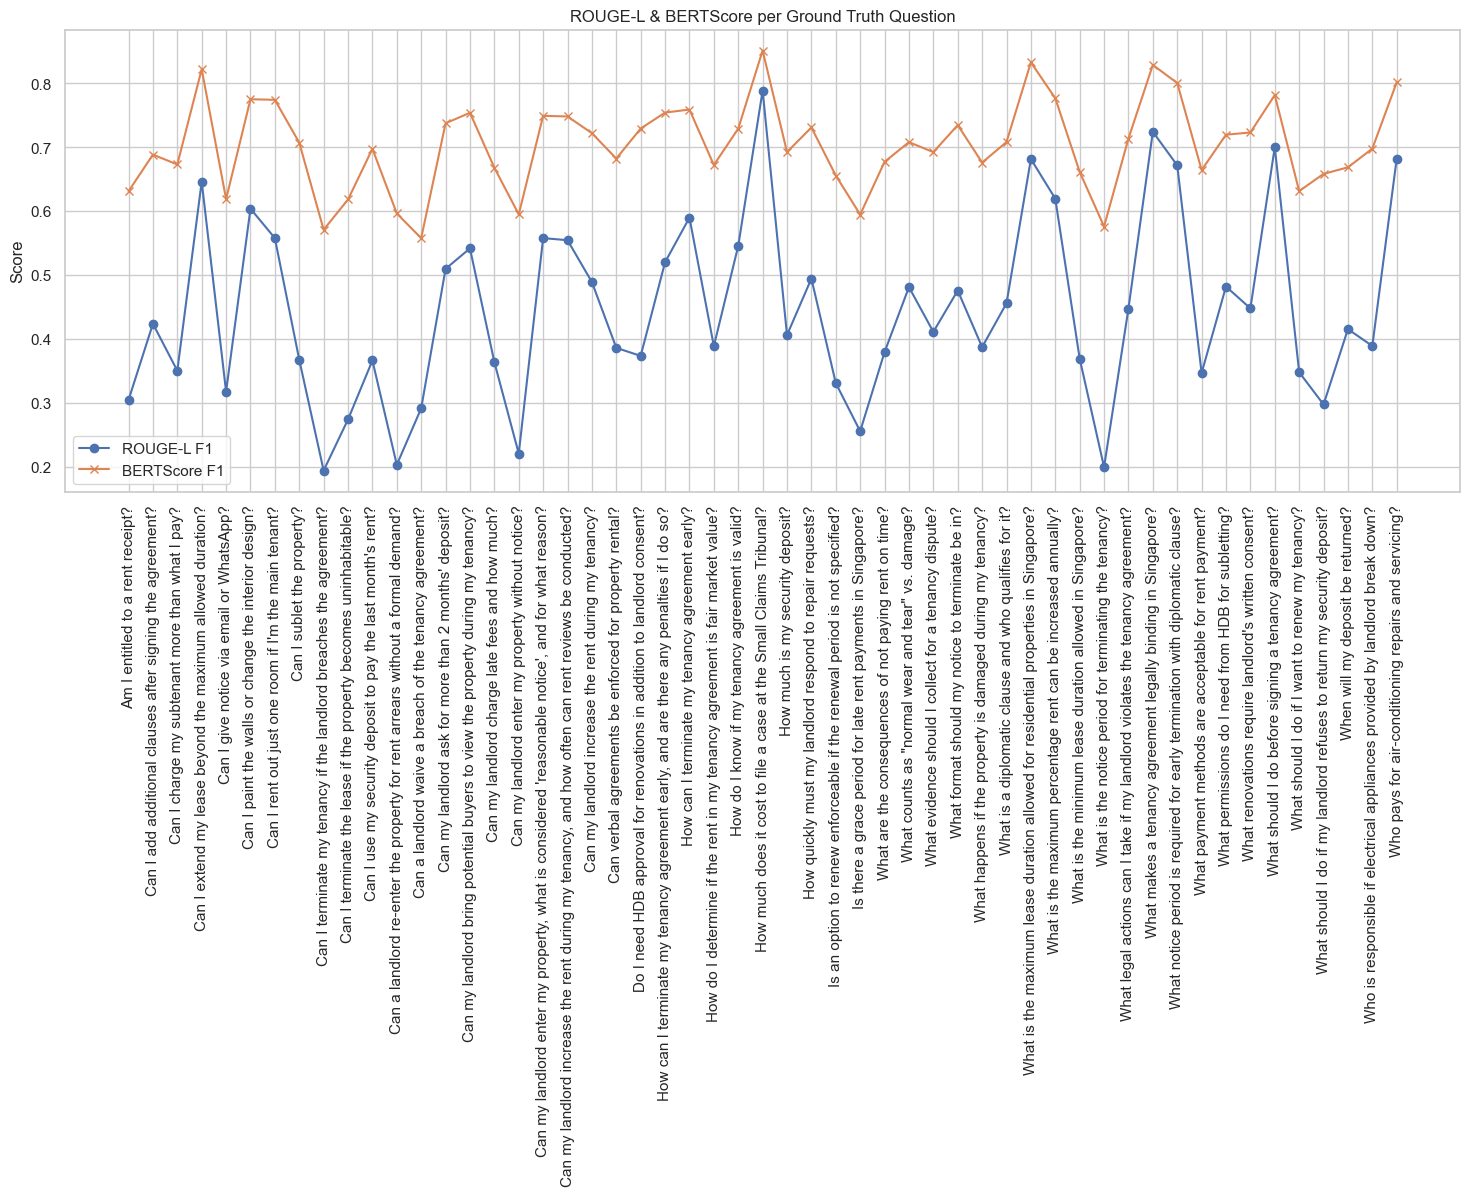

In [26]:
# === 1. IMPORTS ===
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import re
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz  # Untuk fuzzy matching

# LangChain & Models
try:
    from langchain_huggingface import HuggingFaceEmbeddings
except ImportError:
    from langchain.embeddings.huggingface import HuggingFaceEmbeddings

from langchain.vectorstores import FAISS
from langchain_core.documents import Document

# Evaluation
from rouge_score import rouge_scorer
from bert_score import score as bert_scorer

print("✅ Imports complete.")

# === 2. CONFIGURE MODEL & RETRIEVER ===
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
K = 1
embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)
print(f"✅ Embedding model '{MODEL_NAME}' loaded.")

def load_retriever(FAISS_INDEX_PATH, K):
    if not os.path.exists(FAISS_INDEX_PATH):
        raise FileNotFoundError(f"FAISS index not found at {FAISS_INDEX_PATH}.")
    vectorstore = FAISS.load_local(
        FAISS_INDEX_PATH,
        embeddings,
        allow_dangerous_deserialization=True
    )
    return vectorstore.as_retriever(search_kwargs={"k": K})

faiss_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa"
retriever_rag2 = load_retriever(faiss_path, K)
print("✅ FAISS index loaded.")

# === 3. LOAD ORIGINAL FAQ ===
def clean_key(text):
    if not isinstance(text, str):
        return ""
    cleaned = text.lower()
    cleaned = re.sub(r'[^a-z\s]', '', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    return cleaned.strip()

original_file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/Database Requirements.xlsx"
sheet_name = "FAQs (revised)"
df_faqs = pd.read_excel(original_file_path, sheet_name=sheet_name)

question_col_index = 1
answer_col_index = 2

answer_lookup = {}
faq_keys = []
for idx, row in df_faqs.iterrows():
    key = clean_key(row.iloc[question_col_index])
    value = str(row.iloc[answer_col_index]).strip() if pd.notna(row.iloc[answer_col_index]) else ""
    if key and value:
        answer_lookup[key] = value
        faq_keys.append(key)

print(f"✅ Loaded {len(answer_lookup)} FAQ entries.")

# === 4. LOAD PARAPHRASED QUERIES ===
paraphrased_file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/database_queries_paraphrased_FULL_generated.csv"
df_paraphrased = pd.read_csv(paraphrased_file_path)
validation_data = []

FUZZY_THRESHOLD = 80

for idx, row in df_paraphrased.iterrows():
    query = row['query']
    ground_truth_q = row['ground_truth_question']
    cleaned_gt = clean_key(ground_truth_q)
    
    # Exact match first
    if cleaned_gt in answer_lookup:
        answer = answer_lookup[cleaned_gt]
    else:
        best_match, score, _ = process.extractOne(
            cleaned_gt, faq_keys, scorer=fuzz.token_sort_ratio
        )
        answer = answer_lookup[best_match] if score >= FUZZY_THRESHOLD else ""

    validation_data.append({
        "query": query,
        "ground_truth_question": ground_truth_q,
        "expected_answer": answer
    })

validation_df = pd.DataFrame(validation_data)
found_count = validation_df['expected_answer'].apply(lambda x: x.strip() != "").sum()
print(f"✅ Fuzzy matching found answers for {found_count}/{len(validation_df)} queries.")

# === 5. RETRIEVAL & SCORING ===
results = []
for idx, row in tqdm(validation_df.iterrows(), total=len(validation_df)):
    query = row['query']
    expected_answer = row['expected_answer']
    try:
        retrieved_docs = retriever_rag2.invoke(query)
        retrieved_answer_chunk = retrieved_docs[0].page_content if retrieved_docs else ""
    except:
        retrieved_answer_chunk = "---RETRIEVAL ERROR---"

    results.append({
        "query": query,
        "ground_truth_question": row['ground_truth_question'],
        "expected_answer": expected_answer,
        "retrieved_answer_chunk": retrieved_answer_chunk
    })

df_results = pd.DataFrame(results)

# Only valid retrievals
valid_idx = [i for i, (ref, cand) in enumerate(zip(df_results['expected_answer'], df_results['retrieved_answer_chunk']))
             if ref.strip() and cand != "---RETRIEVAL ERROR---"]

valid_candidates = [df_results.iloc[i]['retrieved_answer_chunk'] for i in valid_idx]
valid_references = [df_results.iloc[i]['expected_answer'] for i in valid_idx]

# ROUGE-L
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(r, c)['rougeL'].fmeasure for r, c in zip(valid_references, valid_candidates)]
avg_rouge_l = np.mean(rouge_scores) if rouge_scores else 0.0

# BERTScore
P, R, F1 = bert_scorer(valid_candidates, valid_references, lang='en', verbose=True, model_type='bert-base-uncased')
avg_bert = F1.mean().item()

print(f"\nAverage ROUGE-L F-measure: {avg_rouge_l:.4f}")
print(f"Average BERTScore F1:      {avg_bert:.4f}")

# === 6. ADD LABELS BASED ON THRESHOLDS ===
def label_score(score, metric='rouge'):
    if metric == 'rouge':
        if score >= 0.8:
            return "Excellent"
        elif score >= 0.6:
            return "Good"
        elif score >= 0.4:
            return "Acceptable"
        else:
            return "Poor"
    elif metric == 'bert':
        if score >= 0.85:
            return "Excellent"
        elif score >= 0.7:
            return "Good"
        elif score >= 0.5:
            return "Acceptable"
        else:
            return "Poor"

df_results = df_results.iloc[valid_idx].copy()
df_results['rougeL_f1'] = rouge_scores
df_results['bert_f1'] = F1.tolist()
df_results['ROUGE_label'] = df_results['rougeL_f1'].apply(lambda x: label_score(x, 'rouge'))
df_results['BERT_label'] = df_results['bert_f1'].apply(lambda x: label_score(x, 'bert'))

# Save CSV
output_csv_with_labels = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results_with_labels.csv"
df_results.to_csv(output_csv_with_labels, index=False)
print(f"✅ Results with labels saved to {output_csv_with_labels}")

# === 7. PLOT PER GROUND TRUTH QUESTION ===
agg_df = df_results.groupby('ground_truth_question').agg({
    'rougeL_f1':'mean',
    'bert_f1':'mean'
}).reset_index()

plt.figure(figsize=(18,6))
plt.plot(agg_df['ground_truth_question'], agg_df['rougeL_f1'], marker='o', label='ROUGE-L F1')
plt.plot(agg_df['ground_truth_question'], agg_df['bert_f1'], marker='x', label='BERTScore F1')
plt.xticks(rotation=90)
plt.ylabel("Score")
plt.title("ROUGE-L & BERTScore per Ground Truth Question")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# === Additional Evaluation: ROUGE + BERTScore ===
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import pandas as pd

# valid_references = list of ground truth answers
# valid_candidates = list of model outputs

# 1️⃣ ROUGE-L per query
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, cand)['rougeL'].fmeasure
                for ref, cand in zip(valid_references, valid_candidates)]

# 2️⃣ BERTScore per query
P, R, F1 = bert_score(valid_candidates, valid_references, lang='en')  # change 'en' if using another language
bert_f1_scores = F1.tolist()

# 3️⃣ Combine results per query
evaluation_df = pd.DataFrame({
    'reference': valid_references,
    'candidate': valid_candidates,
    'rougeL_f1': rouge_scores,
    'bert_f1': bert_f1_scores
})

# 4️⃣ Average scores
avg_rougeL = evaluation_df['rougeL_f1'].mean()
avg_bertF1 = evaluation_df['bert_f1'].mean()

print(f"✅ Average ROUGE-L F1: {avg_rougeL:.4f}")
print(f"✅ Average BERTScore F1: {avg_bertF1:.4f}")


evaluation_df.to_csv("rag_evaluation_results.csv", index=False)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Average ROUGE-L F1: 0.4457
✅ Average BERTScore F1: 0.8960


In [15]:
import pandas as pd
import os
import re
from rapidfuzz import process, fuzz
from collections import defaultdict

# === 1. COPY YOUR clean_key FUNCTION ===
def clean_key(text):
    if not isinstance(text, str):
        return ""
    cleaned = text.lower()
    cleaned = re.sub(r'[^a-z\s]', '', cleaned) # Using your exact cleaner
    cleaned = re.sub(r'\s+', ' ', cleaned)
    return cleaned.strip()

print("✅ 'clean_key' function ready.")

# === 2. FILE PATHS (Adjust if needed) ===
original_file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/Database Requirements.xlsx"
sheet_name = "FAQs (revised)"
paraphrased_file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/database_queries_paraphrased_FULL_generated.csv"

# === 3. THRESHOLD (Must match your main script) ===
FUZZY_THRESHOLD = 80

# === 4. LOAD MASTER FAQs (from Excel) ===
try:
    df_faqs = pd.read_excel(original_file_path, sheet_name=sheet_name)
    
    question_col_index = 1  # Column B
    
    # We store two versions: original (for reading) and cleaned (for matching)
    faq_master_list_cleaned = []
    # Lookup: 'cleaned_key' -> 'original_question'
    cleaned_to_original_lookup = {} 

    for idx, row in df_faqs.iterrows():
        original_q = str(row.iloc[question_col_index]).strip()
        if pd.notna(original_q) and original_q:
            cleaned_q = clean_key(original_q)
            if cleaned_q:
                faq_master_list_cleaned.append(cleaned_q)
                if cleaned_q not in cleaned_to_original_lookup:
                    cleaned_to_original_lookup[cleaned_q] = original_q

    faq_master_set_cleaned = set(faq_master_list_cleaned)
    print(f"✅ Loaded {len(faq_master_list_cleaned)} unique FAQs from Excel.")

except FileNotFoundError:
    print(f"❌ ERROR: Excel file not found at {original_file_path}")
    exit()
except Exception as e:
    print(f"❌ ERROR reading Excel: {e}")
    exit()

# === 5. LOAD PARAPHRASED QUERIES (from CSV) ===
try:
    df_paraphrased = pd.read_csv(paraphrased_file_path)
    # Get all unique 'ground_truth_question'
    unique_gt_questions = df_paraphrased['ground_truth_question'].unique()
    print(f"✅ Loaded {len(unique_gt_questions)} unique 'ground_truth_question' entries from CSV.")

except FileNotFoundError:
    print(f"❌ ERROR: CSV file not found at {paraphrased_file_path}")
    exit()
except Exception as e:
    print(f"❌ ERROR reading CSV: {e}")
    exit()


# === 6. PERFORM MATCHING AND FIND FAILURES ===
mismatches = []
match_count = 0

for gt_question in unique_gt_questions:
    if not isinstance(gt_question, str) or not gt_question.strip():
        continue # Skip empty

    cleaned_gt = clean_key(gt_question)

    # 1. Check for a perfect match first
    if cleaned_gt in faq_master_set_cleaned:
        match_count += 1
        continue
        
    # 2. If no perfect match, use fuzzy matching
    best_match, score, _ = process.extractOne(
        cleaned_gt,
        faq_master_list_cleaned, 
        scorer=fuzz.token_sort_ratio
    )
    
    # 3. Check if it passes the threshold
    if score >= FUZZY_THRESHOLD:
        match_count += 1
    else:
        # FAILED! Store the data for reporting
        mismatches.append({
            "csv_ground_truth": gt_question,
            "cleaned_csv_gt": cleaned_gt,
            "best_excel_match_original": cleaned_to_original_lookup.get(best_match, "N/A"),
            "best_excel_match_cleaned": best_match,
            "score": score
        })

# === 7. REPORT THE AUDIT RESULTS ===
print("\n" + "="*40)
print("       GROUND TRUTH AUDIT RESULTS")
print("="*40)
print(f"\nTotal unique 'ground_truth_question' in CSV: {len(unique_gt_questions)}")
print(f"Total unique FAQs in Excel: {len(faq_master_list_cleaned)}")
print(f"Match Threshold: {FUZZY_THRESHOLD}")
print("-" * 40)
print(f"🟢 Successfully Matched: {match_count}")
print(f"🔴 Failed to Match:   {len(mismatches)}")
print("-" * 40)

if mismatches:
    print("\n\nLIST OF 'GROUND_TRUTH_QUESTION' ENTRIES THAT FAILED TO MATCH:\n")
    
    for i, item in enumerate(mismatches):
        print(f"--- {i+1}. FAILED ------------------------")
        print(f"  [CSV]:   '{item['csv_ground_truth']}'")
        print(f"  (Clean): '{item['cleaned_csv_gt']}'")
        print(f"\n  Closest match found in Excel:")
        print(f"  [Excel]: '{item['best_excel_match_original']}'")
        print(f"  (Clean): '{item['best_excel_match_cleaned']}'")
        print(f"  SIMILARITY SCORE: {item['score']:.2f} (BELOW {FUZZY_THRESHOLD})\n")
else:
    print("\n\n🎉 Congratulations! All 'ground_truth_question' entries successfully match the Excel FAQs.")

✅ 'clean_key' function ready.
✅ Loaded 54 unique FAQs from Excel.
✅ Loaded 53 unique 'ground_truth_question' entries from CSV.

       GROUND TRUTH AUDIT RESULTS

Total unique 'ground_truth_question' in CSV: 53
Total unique FAQs in Excel: 54
Match Threshold: 80
----------------------------------------
🟢 Successfully Matched: 53
🔴 Failed to Match:   0
----------------------------------------


🎉 Congratulations! All 'ground_truth_question' entries successfully match the Excel FAQs.


✅ Imports complete.
✅ Embedding model 'sentence-transformers/all-MiniLM-L6-v2' loaded.
✅ FAISS index loaded.
✅ Loaded 54 FAQ entries.
✅ Fuzzy matching found answers for 265/265 queries.


100%|████████████████████████████████████████| 265/265 [00:01<00:00, 151.86it/s]


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 1.48 seconds, 179.19 sentences/sec

Average ROUGE-L F-measure (Answer/Explanation only): 0.9174
Average BERTScore F1 (Answer/Explanation only):      0.9559
✅ Answer/Explanation-only results saved to /Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results_answer_only.csv


/var/folders/qv/l2xzz1097p1g1g5mslsj25vw0000gn/T/ipykernel_29802/1909236245.py:213: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


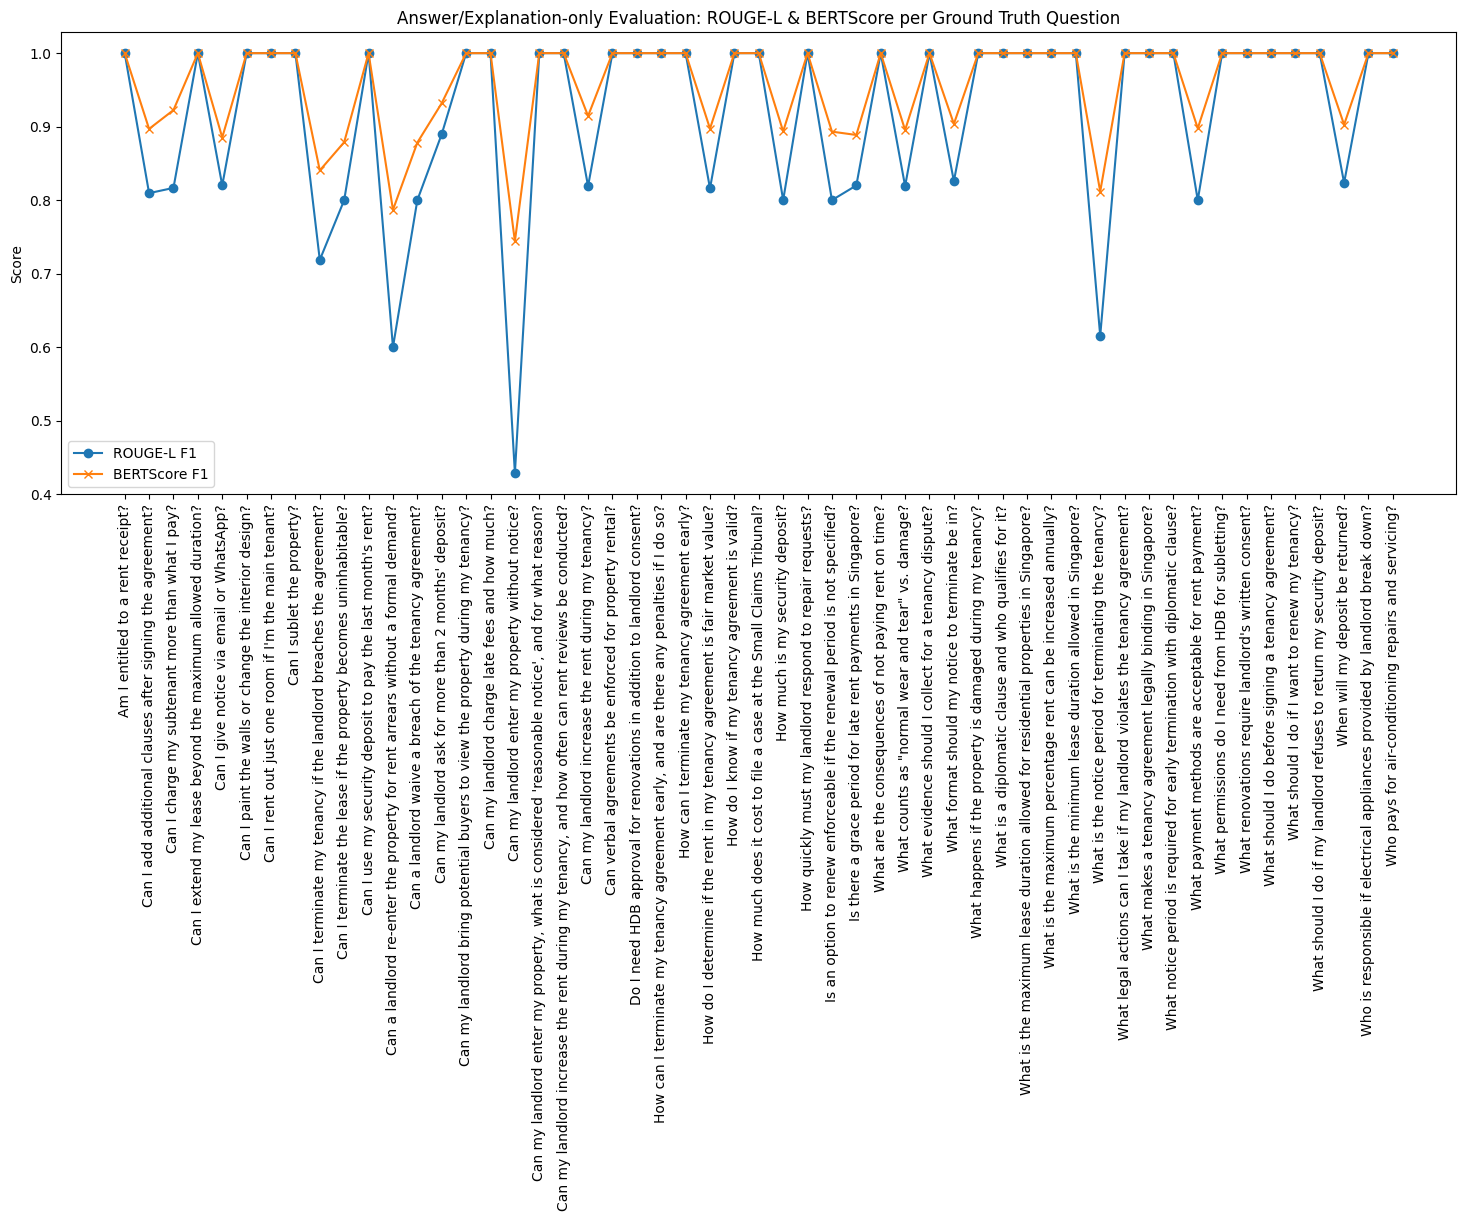

In [9]:
# === 1. IMPORTS ===
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import re
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz  # For fuzzy matching

# LangChain & Models
try:
    from langchain_huggingface import HuggingFaceEmbeddings
except ImportError:
    from langchain.embeddings.huggingface import HuggingFaceEmbeddings

from langchain.vectorstores import FAISS
from langchain_core.documents import Document

# Evaluation
from rouge_score import rouge_scorer
from bert_score import score as bert_scorer

print("✅ Imports complete.")

# === 2. CONFIGURE MODEL & RETRIEVER ===
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
K = 1
embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)
print(f"✅ Embedding model '{MODEL_NAME}' loaded.")

def load_retriever(FAISS_INDEX_PATH, K):
    if not os.path.exists(FAISS_INDEX_PATH):
        raise FileNotFoundError(f"FAISS index not found at {FAISS_INDEX_PATH}.")
    vectorstore = FAISS.load_local(
        FAISS_INDEX_PATH,
        embeddings,
        allow_dangerous_deserialization=True
    )
    return vectorstore.as_retriever(search_kwargs={"k": K})

faiss_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/faiss_index_general_qa"
retriever_rag2 = load_retriever(faiss_path, K)
print("✅ FAISS index loaded.")

# === 3. LOAD ORIGINAL FAQ ===
def clean_key(text):
    if not isinstance(text, str):
        return ""
    cleaned = text.lower()
    cleaned = re.sub(r'[^a-z\s]', '', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    return cleaned.strip()

original_file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/Database Requirements.xlsx"
sheet_name = "FAQs (revised)"
df_faqs = pd.read_excel(original_file_path, sheet_name=sheet_name)

question_col_index = 1
answer_col_index = 2

answer_lookup = {}
faq_keys = []
for idx, row in df_faqs.iterrows():
    key = clean_key(row.iloc[question_col_index])
    value = str(row.iloc[answer_col_index]).strip() if pd.notna(row.iloc[answer_col_index]) else ""
    if key and value:
        answer_lookup[key] = value
        faq_keys.append(key)

print(f"✅ Loaded {len(answer_lookup)} FAQ entries.")

# === 4. LOAD PARAPHRASED QUERIES ===
paraphrased_file_path = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/database_queries_paraphrased_FULL_generated.csv"
df_paraphrased = pd.read_csv(paraphrased_file_path)
validation_data = []

FUZZY_THRESHOLD = 80

for idx, row in df_paraphrased.iterrows():
    query = row['query']
    ground_truth_q = row['ground_truth_question']
    cleaned_gt = clean_key(ground_truth_q)
    
    # Exact or fuzzy match
    if cleaned_gt in answer_lookup:
        answer = answer_lookup[cleaned_gt]
    else:
        best_match, score, _ = process.extractOne(
            cleaned_gt, faq_keys, scorer=fuzz.token_sort_ratio
        )
        answer = answer_lookup[best_match] if score >= FUZZY_THRESHOLD else ""

    validation_data.append({
        "query": query,
        "ground_truth_question": ground_truth_q,
        "expected_answer": answer
    })

validation_df = pd.DataFrame(validation_data)
found_count = validation_df['expected_answer'].apply(lambda x: x.strip() != "").sum()
print(f"✅ Fuzzy matching found answers for {found_count}/{len(validation_df)} queries.")

# === 5. RETRIEVAL & EXTRACT ONLY ANSWER/EXPLANATION ===
def extract_answer(text):
    """
    Extract only the 'Answer/Explanation' part from multi-section text.
    Example input:
    Question: ...
    Answer/Explanation: ...
    Legal Context: ...
    Regulation/Source: ...

    Output: only the content of Answer/Explanation.
    """
    if not isinstance(text, str):
        return ""
    
    match = re.search(
        r"(?i)(?:answer\/explanation|answer)\s*:\s*(.*?)(?:\n[A-Z][a-zA-Z\s\/]*:|$)",
        text,
        re.DOTALL
    )
    if match:
        ans = match.group(1).strip()
        ans = re.sub(r"\s+", " ", ans)  # remove extra newlines or spaces
        return ans
    return text.strip()

results = []
for idx, row in tqdm(validation_df.iterrows(), total=len(validation_df)):
    query = row['query']
    expected_answer = row['expected_answer']
    try:
        retrieved_docs = retriever_rag2.invoke(query)
        retrieved_answer_chunk = retrieved_docs[0].page_content if retrieved_docs else ""
        retrieved_answer_clean = extract_answer(retrieved_answer_chunk)
    except:
        retrieved_answer_clean = "---RETRIEVAL ERROR---"

    results.append({
        "query": query,
        "ground_truth_question": row['ground_truth_question'],
        "expected_answer": expected_answer,
        "retrieved_answer_chunk": retrieved_answer_clean
    })

df_results = pd.DataFrame(results)

# === 6. COMPUTE METRICS (ROUGE-L & BERTScore) ===
valid_idx = [i for i, (ref, cand) in enumerate(zip(df_results['expected_answer'], df_results['retrieved_answer_chunk']))
             if ref.strip() and cand.strip() and cand != "---RETRIEVAL ERROR---"]

valid_candidates = [df_results.iloc[i]['retrieved_answer_chunk'] for i in valid_idx]
valid_references = [df_results.iloc[i]['expected_answer'] for i in valid_idx]

# ROUGE-L
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
rouge_scores = [scorer.score(ref, cand)['rougeL'].fmeasure for ref, cand in zip(valid_references, valid_candidates)]
avg_rouge_l = np.mean(rouge_scores) if rouge_scores else 0.0

# BERTScore
P, R, F1 = bert_scorer(valid_candidates, valid_references, lang='en', verbose=True, model_type='bert-base-uncased')
avg_bert = F1.mean().item()

print(f"\nAverage ROUGE-L F-measure (Answer/Explanation only): {avg_rouge_l:.4f}")
print(f"Average BERTScore F1 (Answer/Explanation only):      {avg_bert:.4f}")

# === 7. LABEL BASED ON THRESHOLDS ===
def label_score(score, metric='rouge'):
    if metric == 'rouge':
        if score >= 0.8:
            return "Excellent"
        elif score >= 0.6:
            return "Good"
        elif score >= 0.4:
            return "Acceptable"
        else:
            return "Poor"
    elif metric == 'bert':
        if score >= 0.85:
            return "Excellent"
        elif score >= 0.7:
            return "Good"
        elif score >= 0.5:
            return "Acceptable"
        else:
            return "Poor"

df_results = df_results.iloc[valid_idx].copy()
df_results['rougeL_f1'] = rouge_scores
df_results['bert_f1'] = F1.tolist()
df_results['ROUGE_label'] = df_results['rougeL_f1'].apply(lambda x: label_score(x, 'rouge'))
df_results['BERT_label'] = df_results['bert_f1'].apply(lambda x: label_score(x, 'bert'))

# Save results
output_csv_with_labels = "/Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results_answer_only.csv"
df_results.to_csv(output_csv_with_labels, index=False)
print(f"✅ Answer/Explanation-only results saved to {output_csv_with_labels}")

# === 8. PLOT PER GROUND TRUTH QUESTION ===
agg_df = df_results.groupby('ground_truth_question').agg({
    'rougeL_f1':'mean',
    'bert_f1':'mean'
}).reset_index()

plt.figure(figsize=(18,6))
plt.plot(agg_df['ground_truth_question'], agg_df['rougeL_f1'], marker='o', label='ROUGE-L F1')
plt.plot(agg_df['ground_truth_question'], agg_df['bert_f1'], marker='x', label='BERTScore F1')
plt.xticks(rotation=90)
plt.ylabel("Score")
plt.title("Answer/Explanation-only Evaluation: ROUGE-L & BERTScore per Ground Truth Question")
plt.legend()
plt.tight_layout()

# Save the figure as a PNG file
plt.savefig("evaluation_per_question.png", dpi=300)

# Show the plot
plt.show()

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# Convert texts to embeddings
candidate_embeddings = embeddings.embed_documents(valid_candidates)
reference_embeddings = embeddings.embed_documents(valid_references)

# Compute cosine similarity per pair
vector_sims = []
for cand_vec, ref_vec in zip(candidate_embeddings, reference_embeddings):
    sim = cosine_similarity([cand_vec], [ref_vec])[0][0]
    vector_sims.append(sim)

avg_vector_sim = np.mean(vector_sims) if vector_sims else 0.0
print(f"Average vector similarity (cosine): {avg_vector_sim:.4f}")

Average vector similarity (cosine): 0.9484


In [7]:
def vector_label(score):
    if score >= 0.85:
        return "Excellent"
    elif score >= 0.7:
        return "Good"
    elif score >= 0.5:
        return "Acceptable"
    else:
        return "Poor"

df_results['vector_sim'] = vector_sims
df_results['Vector_label'] = df_results['vector_sim'].apply(vector_label)

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# --- Prepare valid candidates & references (Answer/Explanation only) ---
valid_candidates = [df_results.iloc[i]['retrieved_answer_chunk'] for i in valid_idx]
valid_references = [df_results.iloc[i]['expected_answer'] for i in valid_idx]

# --- Compute embeddings ---
candidate_embeddings = embeddings.embed_documents(valid_candidates)
reference_embeddings = embeddings.embed_documents(valid_references)

# --- Compute cosine similarity per pair ---
vector_sims = []
for cand_vec, ref_vec in zip(candidate_embeddings, reference_embeddings):
    sim = cosine_similarity([cand_vec], [ref_vec])[0][0]
    vector_sims.append(sim)

avg_vector_sim = np.mean(vector_sims) if vector_sims else 0.0
print(f"Average vector similarity (cosine): {avg_vector_sim:.4f}")

# --- Add similarity & label to df_results ---
def vector_label(score):
    if score >= 0.85:
        return "Excellent"
    elif score >= 0.7:
        return "Good"
    elif score >= 0.5:
        return "Acceptable"
    else:
        return "Poor"

df_results['vector_sim'] = vector_sims
df_results['Vector_label'] = df_results['vector_sim'].apply(vector_label)

#save to CSV ---
df_results.to_csv("/Users/vivianwitjaksono/Desktop/DS5105-Project-new/rag2_validation_results_with_vectors.csv", index=False)
print("✅ Vector similarity scores and labels saved.")

Average vector similarity (cosine): 0.9484
✅ Vector similarity scores and labels saved.
